In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy
import pickle

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chess games

- 100 players
- 2 groups (white and black)
- Can change groups 

In [40]:
N = 600
beta = 0.4
alpha = 1 
K1 = 20
K2 = 5
p_ij = 1 / (1 + np.exp(-2*beta))

variance = 1 / np.sqrt(alpha * beta)
# individual_scores = np.random.normal(1, variance, N)

a1 = list(np.random.normal(3, 5/2, 200))
a2 = list(np.random.normal(0, 1, 200))
a3 = list(np.random.normal(-3, 2, 200))
individual_scores = np.array(a1+a2+a3)

k = 4
# theta = np.array([0.5, 0]) # white gets +0.5 advantage
theta = np.random.uniform(-3, 3, size=k)

groups_1 = np.random.randint(0, k, N)
G_1 = np.zeros((N, k))
for j, g_j in enumerate(groups_1):
    G_1[j, g_j] = 1
    
ranks_1 = individual_scores + np.matmul(G_1, theta)
ranks_1 = ranks_1 - np.min(ranks_1)
    
# G_2 = np.abs(G_1 - 1)
groups_2 = np.random.randint(0, k, N)
G_2 = np.zeros((N, k))
for j, g_j in enumerate(groups_2):
    G_2[j, g_j] = 1

ranks_2 = individual_scores + np.matmul(G_2, theta)
ranks_2 = ranks_2 - np.min(ranks_2)

individual_scores = individual_scores - np.min(individual_scores)

In [41]:
Z_1 = 0
Z_2 = 0
scaled_energy_1 = np.zeros((N, N))
scaled_energy_2 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        energy_1_ij = 0.5 * np.power(ranks_1[i] - ranks_1[j] - 1, 2)
        scaled_energy_1[i, j] =  np.exp(-beta * energy_1_ij)
        Z_1 += scaled_energy_1[i, j]
        
        energy_2_ij = 0.5 * np.power(ranks_2[i] - ranks_2[j] - 1, 2)
        scaled_energy_2[i, j] =  np.exp(-beta * energy_2_ij)
        Z_2 += scaled_energy_2[i, j]
c_1 = K1*N / Z_1
c_2 = K2*N / Z_2

A_1 = np.zeros((N, N))
A_2 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        if A_1[i, 0] == A_1[j, 1]:
            A_1[i, j] = np.random.poisson(c_1 * scaled_energy_1[i, j])
            A_2[i, j] = np.random.poisson(c_2 * scaled_energy_2[i, j])

In [42]:
test_id = "Test8"

In [43]:
test_data = {
    "a": individual_scores,
    "ranks1": ranks_1,
    "ranks2": ranks_2,
    "G1": G_1,
    "G2": G_2,
    "A1": A_1,
    "A2": A_2
}

with open("../../data/tests/" + test_id + "_data.pickle", 'wb') as handle:
    pickle.dump(test_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open("../../data/tests/" + test_id + "_data.pickle", 'rb') as handle:
    test_data = pickle.load(handle)

individual_scores = test_data["a"]
ranks_1 = test_data["ranks1"]
ranks_2 = test_data["ranks2"]
A_1 = test_data["A1"]
A_2 = test_data["A2"]
G_1 = test_data["G1"]
G_2 = test_data["G2"]

## Solve

In [45]:
# Construct full operator with Laplacian

L1, d1 = tl.laplacian(A_1)
L2, d2 = tl.laplacian(A_2)
# k = 0.5
# L2 = np.matmul(k*np.eye(N), L1)
# d2 = k * d1

LHS_top1 = np.concatenate((L1, np.matmul(L1, G_1)), axis=1)
LHS_bot1 = np.concatenate((L2, np.matmul(L2, G_2)), axis=1)
# LHS = np.concatenate((LHS_top1, LHS_bot1), axis=0)
LHS = np.concatenate((LHS_top1, np.matmul(G_2.T, LHS_bot1)), axis=0)

# RHS = np.concatenate((d1, d2), axis=0)
RHS = np.concatenate((d1, np.matmul(G_2.T, d2)), axis=0)

In [46]:
print("Shape:", LHS.shape)
print(" Rank: ", LA.matrix_rank(LHS))

Shape: (604, 604)
 Rank:  602


In [47]:
# Solve
result = LA.lstsq(LHS, RHS, rcond=None)
x = result[0]

a_est = x[:N]
theta_est = x[N:]

In [48]:
beta_hat = tl.get_temperature(a_est, A_1+A_2, p_ij=p_ij)

a_est = (a_est - np.min(a_est)) * beta_hat
theta_est = (theta_est - np.min(theta_est)) * beta_hat

s_1 = a_est + np.matmul(G_1, theta_est)
s_2 = a_est + np.matmul(G_2, theta_est)

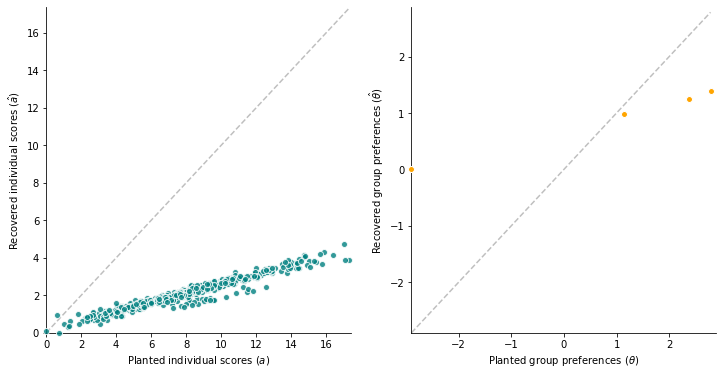

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

xy_line = [[np.min(np.minimum(individual_scores, a_est)), np.max(np.maximum(individual_scores, a_est))],
           [np.min(np.minimum(theta, theta_est)), np.max(np.maximum(theta, theta_est))]]
for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].plot(xy_line[i], xy_line[i], linestyle="dashed", color="grey", alpha=0.5)
    ax[i].set_xlim(xy_line[i][0], xy_line[i][1]+0.1)
    ax[i].set_ylim(xy_line[i][0], xy_line[i][1]+0.1)

ax[0].scatter(individual_scores, a_est, color="teal", edgecolor="white", alpha=0.8, clip_on=False, zorder=100)
ax[0].set_xlabel(r"Planted individual scores ($a$)")
ax[0].set_ylabel(r"Recovered individual scores ($\hat{a}$)")

ax[1].scatter(theta, theta_est, color="orange", edgecolor="white", alpha=1, clip_on=False, zorder=100)
ax[1].set_xlabel(r"Planted group preferences ($\theta$)")
ax[1].set_ylabel(r"Recovered group preferences ($\hat{\theta}$)")

plt.savefig("../../figures/" + test_id + ".PNG", dpi=200, bbox_inches="tight")

plt.show()